# Modeling Neutron Star Structure

The goal of this project is to create a model that represents the structure of a neutron star. The first step in doing this is by solving the Tolman-Oppenheimer-Volkoff equations:

$$
\dfrac{dp}{dr} = -G(\rho(1 + \dfrac{\epsilon}{c^2}) + \dfrac{p}{c^2}) \dfrac{d\phi}{dr} $$

$$\dfrac{dm}{dr} = 4\pi{}r^2\rho(1 + \dfrac{\epsilon}{c^2})$$

$$\dfrac{d\phi}{dr} = \dfrac{m + 4\pi{}r^3\frac{p}{c^2}}{r(r-2G\frac{m}{c^2})}$$

In order to solve these, we need boundary conditions and to link pressure to mass-density ($\rho$). We do this through an equation of state. We'll start with the simplest option, a polytropic EOS: \
$p = K\rho^\gamma$ \
where $K$ is some constant, and $\gamma = \dfrac{d\ln{p}}{d\ln{\rho}}$

To begin, we will take values from "Static Spherically-Symmetric Stellar Structure in General Relativity" by Christian D. Ott - 2013: 
\
$\gamma = 2.75$ 
\
$K = 30000$


For our central mass densities, our lower bound is determined by the nuclear density value. We know the core of neutron stars are denser than the nuclear saturation density ($2.7$-$2.8$ x $10^{14}$ gcm$^{-3}$), so we'll choose our lower bound to be $2.95$ x $10^{14}$ gcm$^{-3}$. Our upper bound will be near the upper limit for the mass of a neutron star (~$2$-$2.3$ M$_{☉}$), $\rho_c = 2.5$ x $10^{15}$ gcm$^{-3}$. We will have to be careful dealing with the stars near these values, as they will be pushing the bounds of my models.

With that said, lets model a neutron star!

In [1]:
import polytropic as pt

The polytropic script solves the above TOV equations for the above EOS. \
The input parameters are: 
* central mass densities (cgs units)
* gamma
* k

With optional parameters:
* starting radius = 1 cm
* dr = 50 cm

In [2]:
import numpy as np

central_mass_densities = np.linspace(2.95e14, 2.5e15, 15)
gamma = 2.75
k = 30000

Lets try it!

C:\Users\nateh\JupyterNotebooks\polytropic.py:29: RuntimeWarning: invalid value encountered in scalar power
  mass_density = (pressure / k)**(1/gamma)


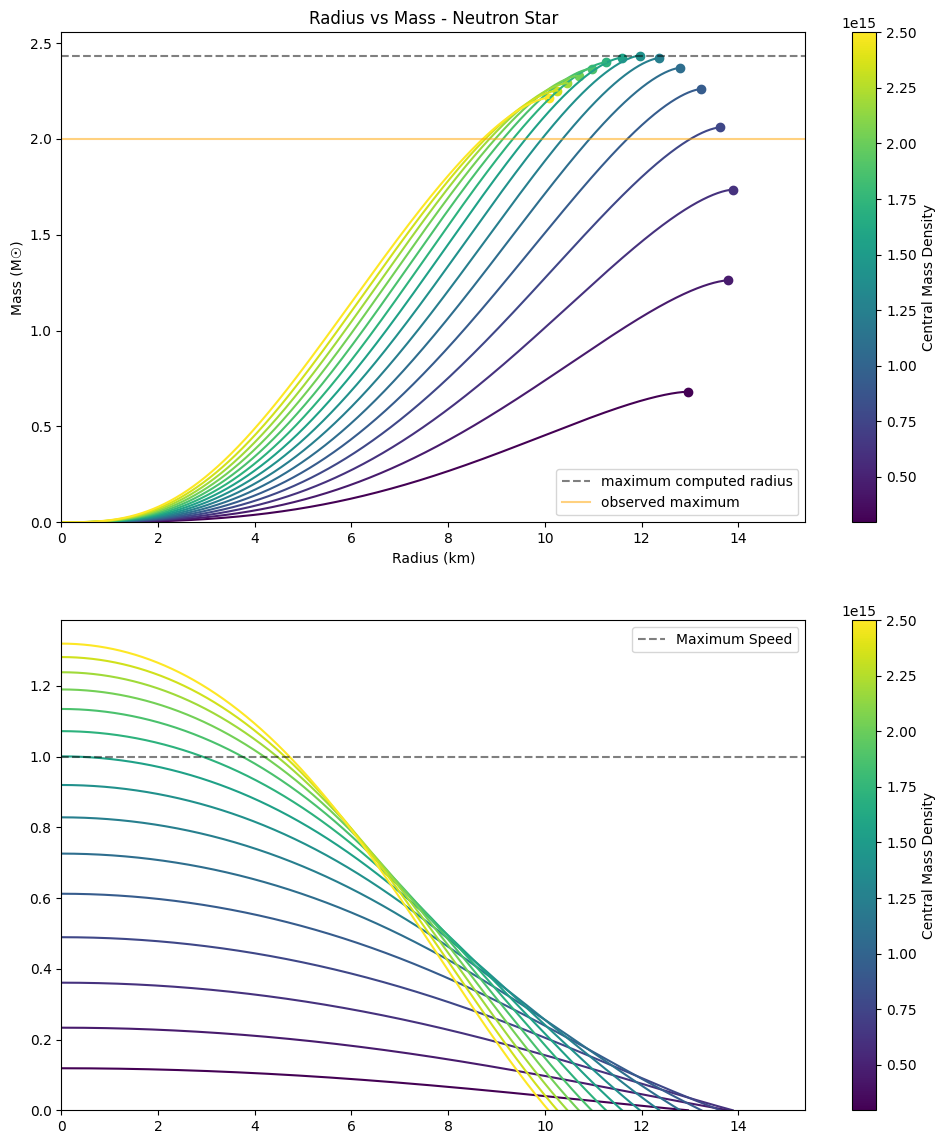

In [3]:
data = pt.neutron_star(central_mass_densities, gamma, k)

Very interesting results! The Mass-Radius curve in the first plot closely resembles neutron star MR curves from literature, like this one: 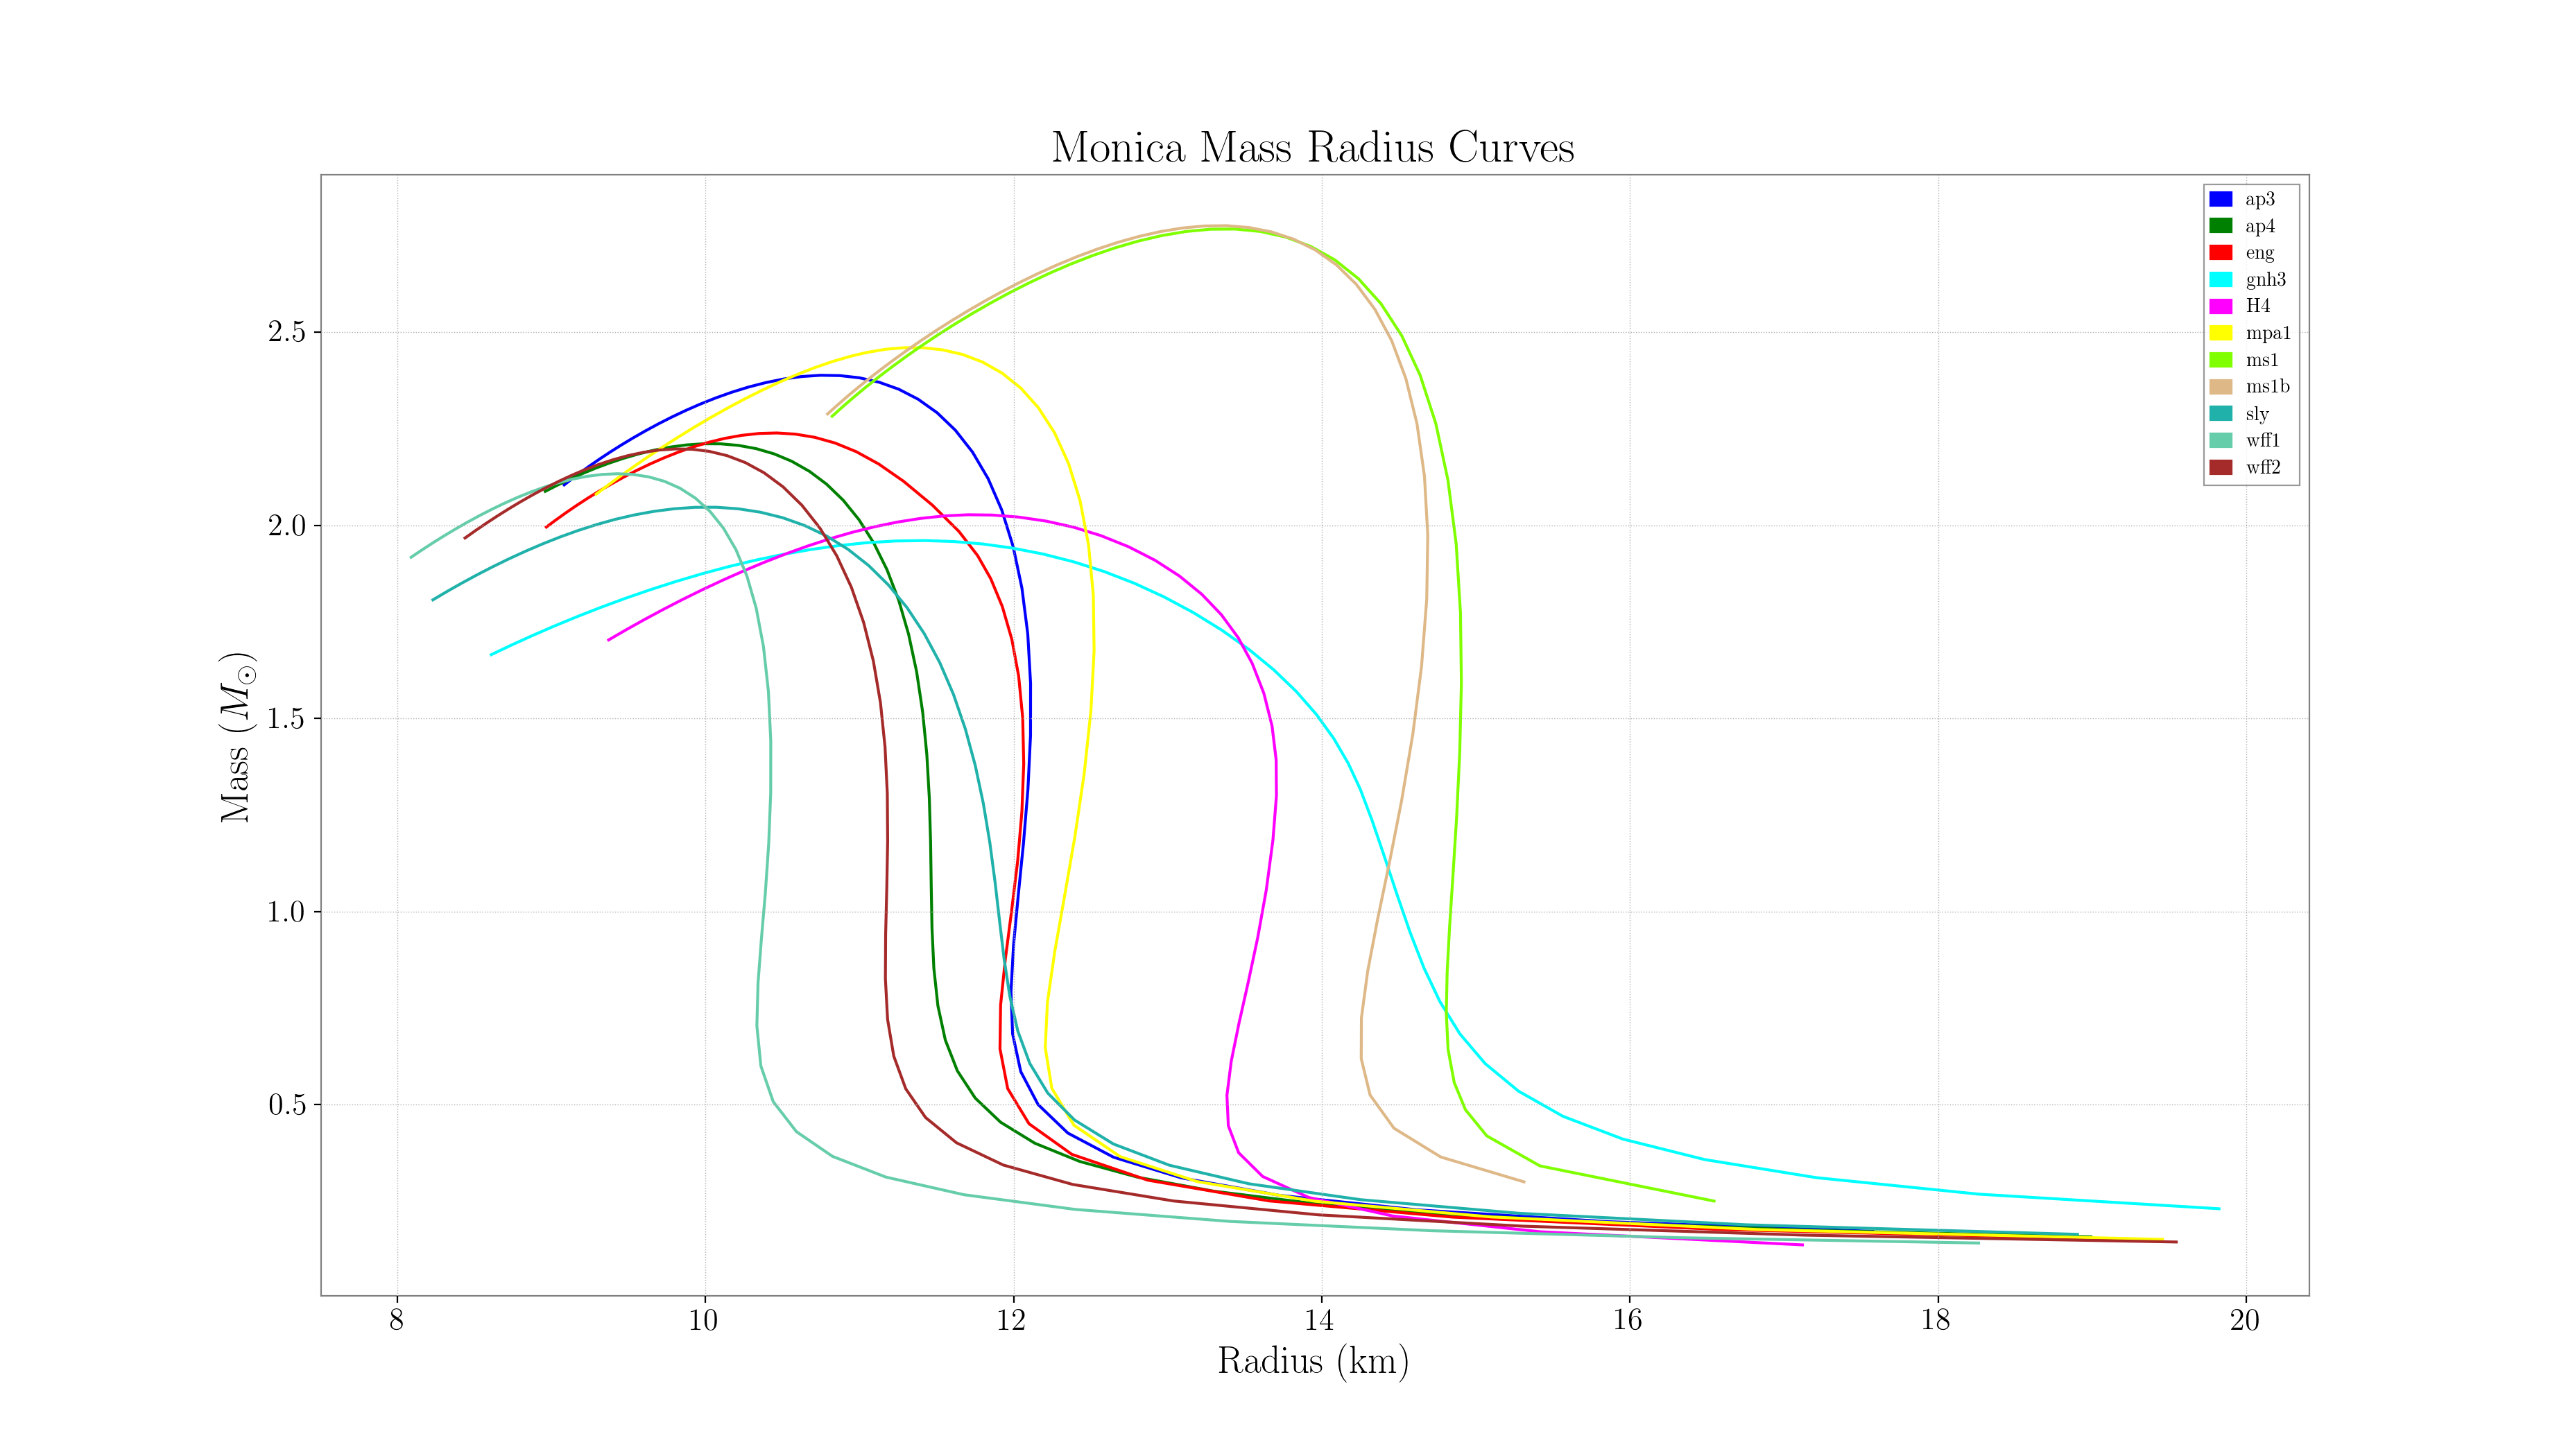 (https://gwemlightcurves.github.io/examples/eos.html)


If you're having trouble seeing the resemblance, look at the points at the end of each of the curves. Trace the line connecting each of these points, and you'll see a curve similar to this!

There is an issue, however. Look at the second graph -- it displays the speed of sound radially throughout the star. For severals central mass-densities, the speed of sound is GREATER than the speed of light for several km!! That is very unphysical, so something must be up. Of course, these occur sort of near the upper mass limit, but there are 6, arguably 7 stars that are above this limit. That feels like too many.


What should we do? First we could look at the parameters we used, $\gamma$ and $K$. We took them from Ott (2013), but we have no idea where these came from. Lets try and find out own:

## Tabular Data

The way we are going to do this is by using tabular data sets, which are precomputed tables of the EOS and other related values. These use very realistic micro-physics that would take too long to simulate (in an entire neutron star). 

We are going to look at the $\mathbf{SLy9}$ dataset available on CompOSE. The related files are called eos.nb and eos.thermo. .n gives the baryon number densities, which can be turned into mass densities, and .thermo gives related thermodynamic information, which for our purposes includes pressures (and energy density).

In [3]:
import tabular_analysis as tb

Let's see what this dataset gives us! First we can graph the log-log relation of density and pressure (EOS):

C:\Users\nateh\JupyterNotebooks\tabular_analysis.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


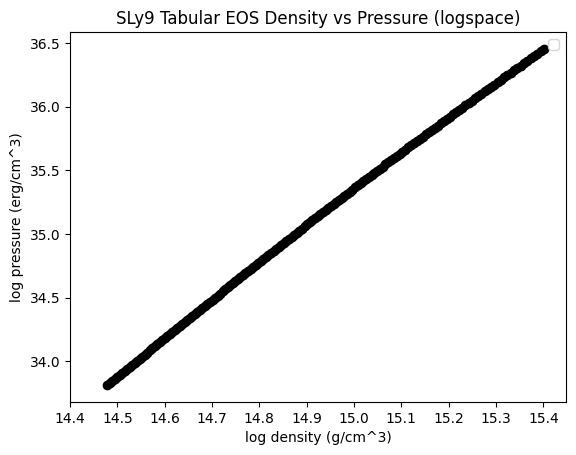

In [5]:
tb.graph_tabular('eos.nb', 'eos.thermo')

Nice! Now, recall that $\gamma = \dfrac{d\ln{p}}{d\ln{\rho}}$. That means that the slope of this line right above will give us a new value of $\gamma$! Let's fit a line to this.

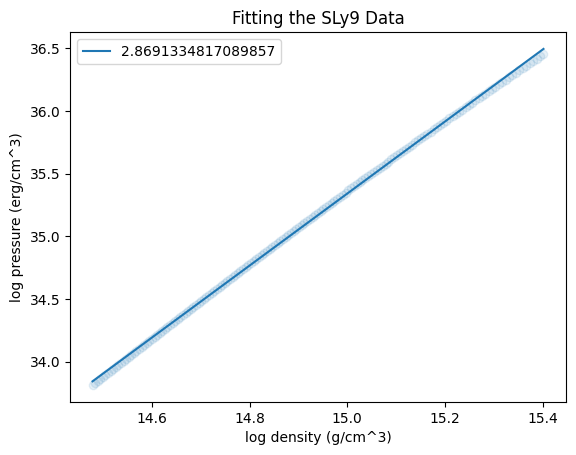

In [4]:
# grabbing density and pressure values
data = tb.read_tabular_Sly('eos.nb', 'eos.thermo')
densities, pressures, epsilons = data

# plotting them
slopes = tb.fit_tabular(densities, pressures)

So we have a new value of $\gamma = 2.87$! We only need a new value of $K$ to match, and we can use our EOS to find it! I went ahead and picked the values of pressure and density at the same radius, so now lets solve for $K$

In [10]:
tab_mass_density, tab_pressure = 10**14.68512146, 10**34.43729934
gamma = 2.87

K = tab_pressure / (tab_mass_density ** gamma)

# Now we have to adjust the units of K
radius_, mass_, mass_density_, internal_energy_, pressure_, k_ = pt.normalizing_values(gamma)
K = K / k_
print(K)

40311.807956013254


Similar to prior, but definitely different! Let's run a new set of stars:

C:\Users\nateh\JupyterNotebooks\polytropic.py:29: RuntimeWarning: invalid value encountered in scalar power
  mass_density = (pressure / k)**(1/gamma)


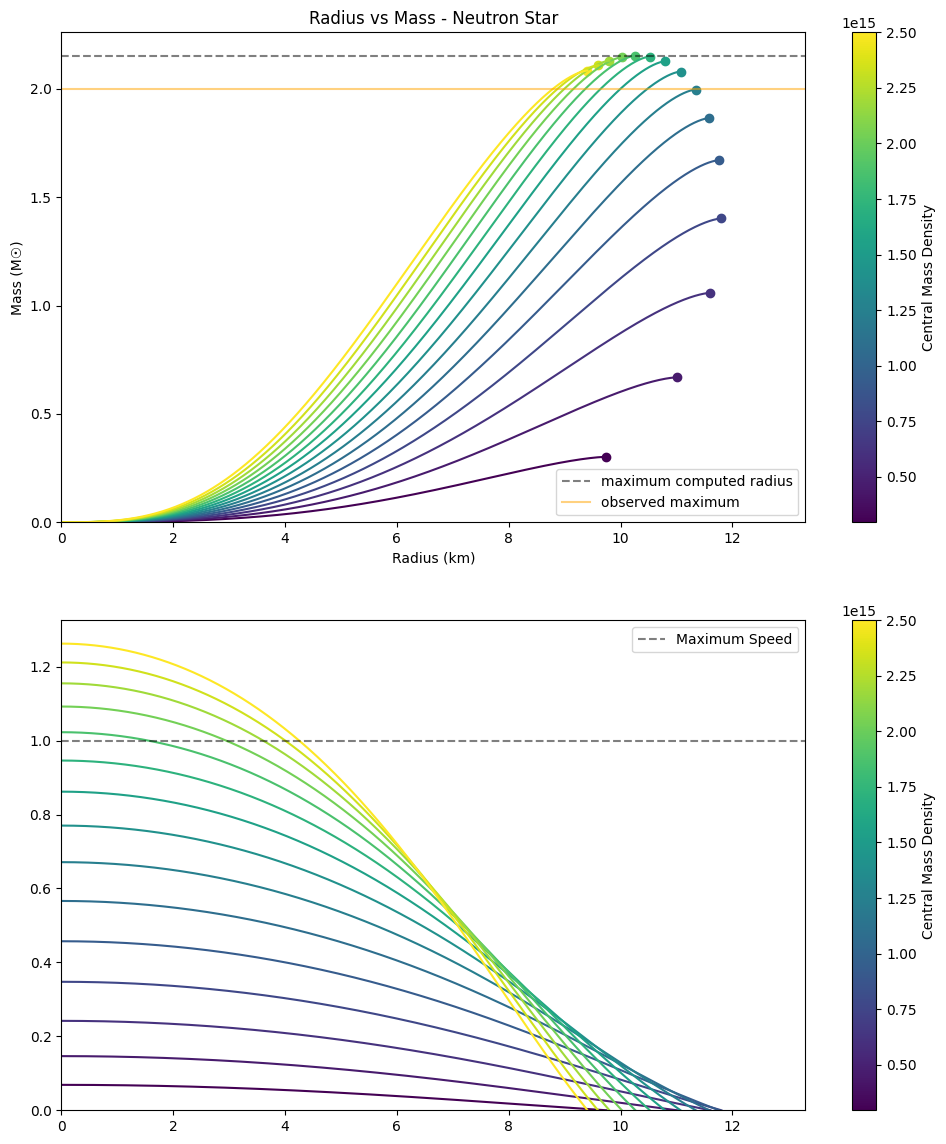

In [11]:
data = pt.neutron_star(central_mass_densities, gamma, K)

Result: It's a bit better! We see in our M/R graph that both mass and radius generally decreased across the board, meaning this data-set is biased towards smaller neutron stars. However, we also see that our sound-speed graph slightly improved! Now only 4-5 of the stars are above the speed of light near the core, and for slightly less radial distance!

We can still do better than this, though. We've already changed both $\gamma$ and $K$, so now our focus should shift to our EOS. We are using a polytropic EOS, which is fairly accurate for neutron stars, but we can do better. Lets try a piecewise polytropic, parametrized by:

$p = K_1\rho^{\gamma^1} + K_2\rho^{\gamma^2} + K_3\rho^{\gamma^3}$ ...

Now we can fit our EOS to a changing pressure-density relation, under the assumption that $\gamma$ is constant from $\rho_i$ to $\rho_{i+1}$

Let's go back to the tabular data graph again:

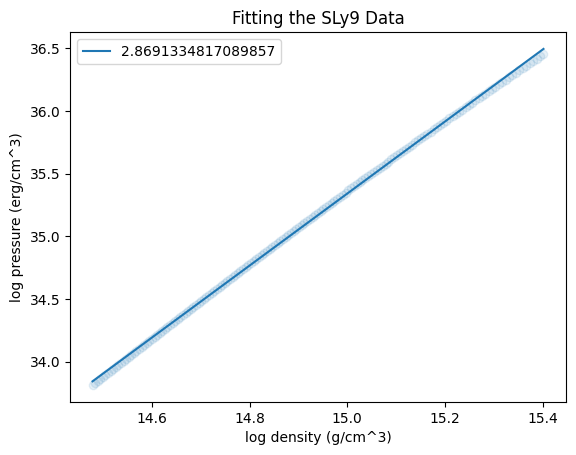

In [12]:
slopes = tb.fit_tabular(densities, pressures)

It's clear that the data behind our best fit line is not linear -- it slightly curves throughout. Lets plot it without the best fit line again to the boundaries better:

C:\Users\nateh\JupyterNotebooks\tabular_analysis.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


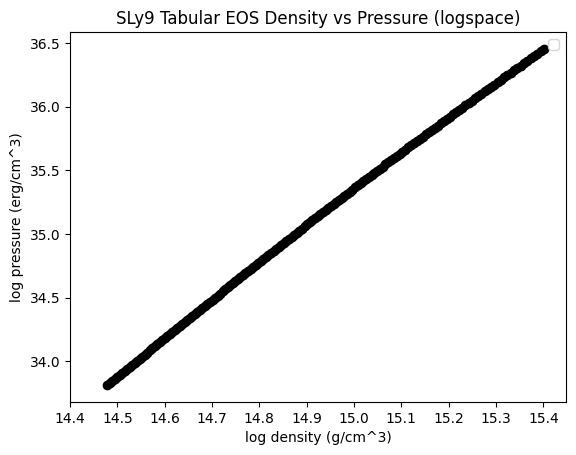

In [13]:
tb.graph_tabular('eos.nb', 'eos.thermo')

Roughly speaking, let's try density boundaries at $\log{\rho} = 14.7, 14.9, 15$

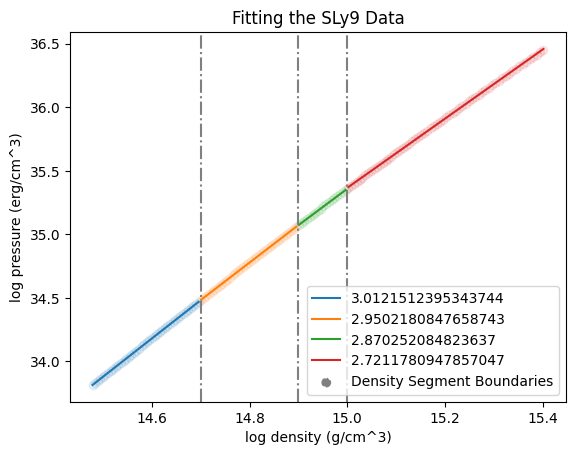

In [5]:
slopes = tb.fit_tabular(densities, pressures, boundaries = [14.7, 14.9, 15])

And now our best fit lines are entirely within the data for our boundaries! Woo!! This will, however, require a new script, so let's try it:

In [1]:
import piecewise_polytropic as ppt

This script solves our new parametric EOS using the TOV equations.
The input parameters for solving the neutron star are: 
* central mass densities (cgs units)
* gamma_values
(it calculates K independently, more complicated formula this time)

With optional parameters:
* density_cutoffs = np.array([14.7, 14.9, 15])
* starting radius = 1 (cm)
* dr = 50 (cm)
* all_data = False
  * all_data is an array of tuples, each containing (per star): radii, masses, pressures, mass_densities, metric_potentials, tidal_ys, tidal, k2
 

We need our gamma values and central mass densities, so let's find those:

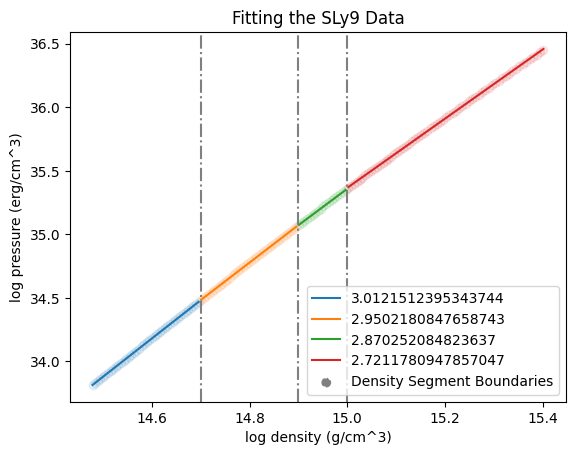

In [8]:
data = tb.read_tabular_Sly('eos.nb', 'eos.thermo')
densities, pressures, epsilons = data

slopes = tb.fit_tabular(densities, pressures, boundaries = [14.7, 14.9, 15])

central_mass_densities = np.linspace(2.95e14, 2.5e15, 15)

C:\Users\nateh\JupyterNotebooks\piecewise_polytropic.py:28: RuntimeWarning: invalid value encountered in scalar power
  mass_density = (pressure / k)**(1/gamma)


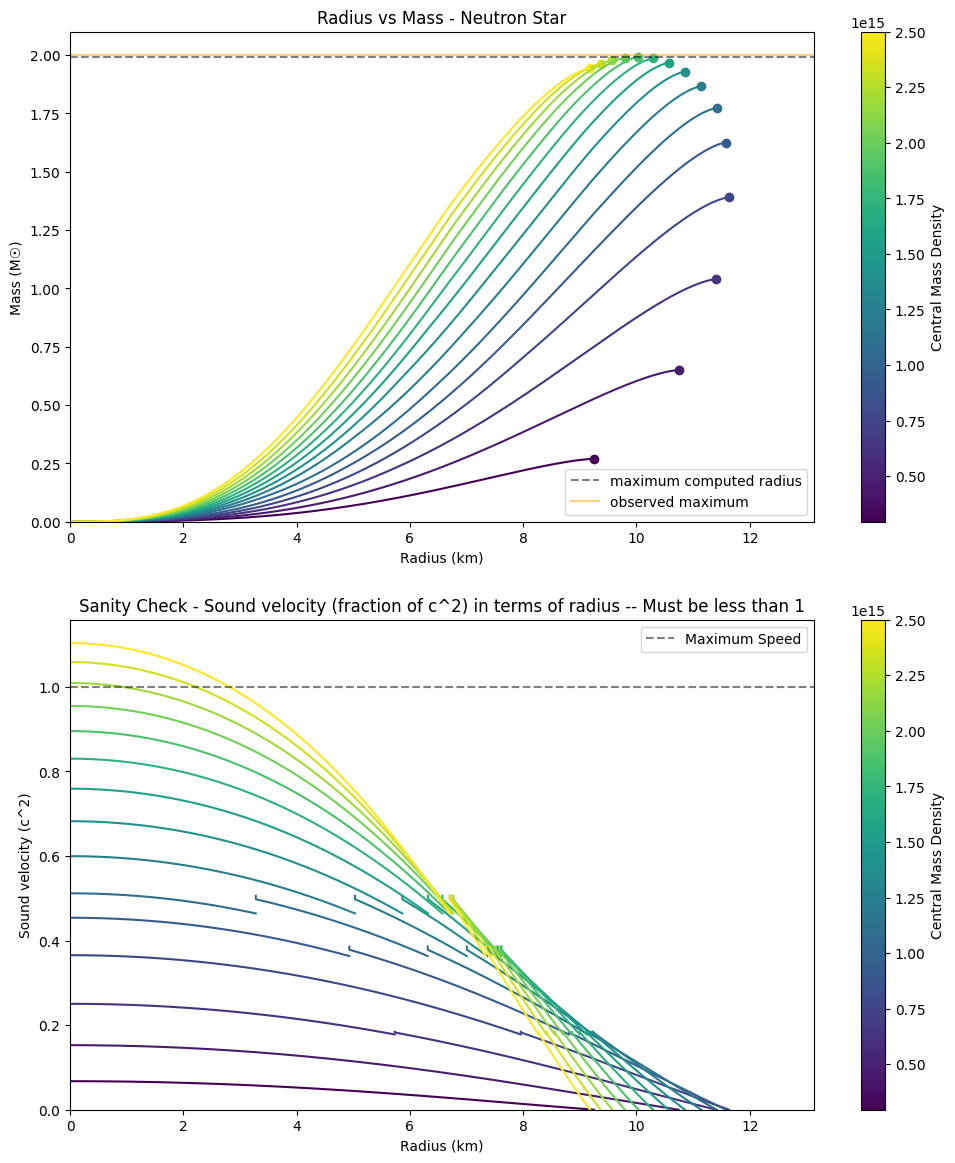

In [10]:
# Lets run a star! Our density cutoffs are the pre-set parameter for ppt.neutron_star, so we don't need it!
masses, radii, tidal_deformability = ppt.neutron_star(central_mass_densities, slopes)

Our results are much better! Our speed of sound is finally constrained to just the upper three central pressures, which is acceptable, and our MR curve looks really nice! The gaps in the sound-speed graph are because of the polytropic EOS, but thats okay -- the graph does NOT require continuity (physically)!


If you would like to take a closer look at other parameters not graphed here, try all_data = True -- this will return an extra parameter, all_data, and is an array of tuples containing, per star, radii, masses, pressures, mass_densities, metric_potentials, tidal_ys, tidal, k2 (in order). So you can plot radii vs pressure, or density vs pressure, etc for any/all of the stars!

The piecewise_polytropic.py script comes with another functionality, however. It also calculates:

# Tidal Deformability ($\Lambda$)

Tidal deformability is a measure of how easily a neutron star is distorted by an external gravitational field, making it an extremely useful metric to know. This is because of the fact that most neutron stars, whose values of mass and radius we can calculate, are in binary systems. This means that tidal deformability is one of the only parameters we CAN calculated based on observables! A large $\Lambda$ means a very deformable star, so it's very puffy, and a small $\Lambda$ means a compact and stiff star.

This is a useful parameter as it's used as an additional constraint on neutron star radius other than mass, helps define EOS models, and is also a connection to gravitational waves.

$\Lambda$ is derived as follows:

The TOV equations are derived the Einstein equations, from which the full metric of spacetime is defined as: 
$$g_{\alpha\beta} = g_{\alpha\beta}^{(0)} + h_{\alpha\beta}$$

We are looking at $h_{\alpha\beta}$, which is spacetime's linearized metric pertubation due to some quadrupolar field, or rather external gravitational field in our case. Solving for the spherical harmonics $l=2$ case, we write $h_{\alpha\beta}$ as:
$$h_{\alpha\beta} = diag[-e^{\nu(r)}H_0(r),e^{\lambda(r)}H_2(r),r^2K(r),r^2sin^2\theta{}K(r)]Y_{2m}(\theta,\psi)$$

This equation can be simplified using $-H_2=H_0=H$, from which we can write the following ODE:
$$H^{''} + H^{'}(\dfrac{2}{r} + e^{\lambda}[\dfrac{2m(r)}{r^2} + 4\pi{}r(p-\epsilon)])) + H[-\dfrac{6e^{\lambda}}{r^2} + 4\pi{}e^{\lambda}(5\epsilon + 9p + \dfrac{\epsilon + p}{dp/d\epsilon})-\nu^2] = 0$$

Where $\epsilon$ is the energy density, $p$ is the pressure, and $e^{\lambda}=(1-\dfrac{2m(r)}{r})^{-1}$. For notations sake, lets call the $H^{'}$ coefficient $F(r)$, and the $H$ coefficient $Q(r)$

In order to solve this, I set $y=R\dfrac{H^{'}(r)}{H(r)}$, which gives the new first order ODE:
$$y^{'} = \dfrac{-y^2}{r} - \dfrac{F(r)}{r}y - rQ(r)$$

This is the ODE that I solved alongside the structure of the neutron star, and after some calculation described in section 3 of Hinderer 2008 we get the love number $K_2$, and the dimensionless tidal deformability $\Lambda = \frac{2}{3}k_2(\dfrac{c^2R}{GM})^5$. $\Lambda$'s extreme dependence on $(\dfrac{R}{M})^5$ is notable, as any small change in the EOS/radius will cause massive reprocussions for the tidal deformability. Typical ranges in literature are from 100-1500, but a good, constrained tidal deformability should be in the range of 300-800. Let's see what we got from this piecewise EOS!

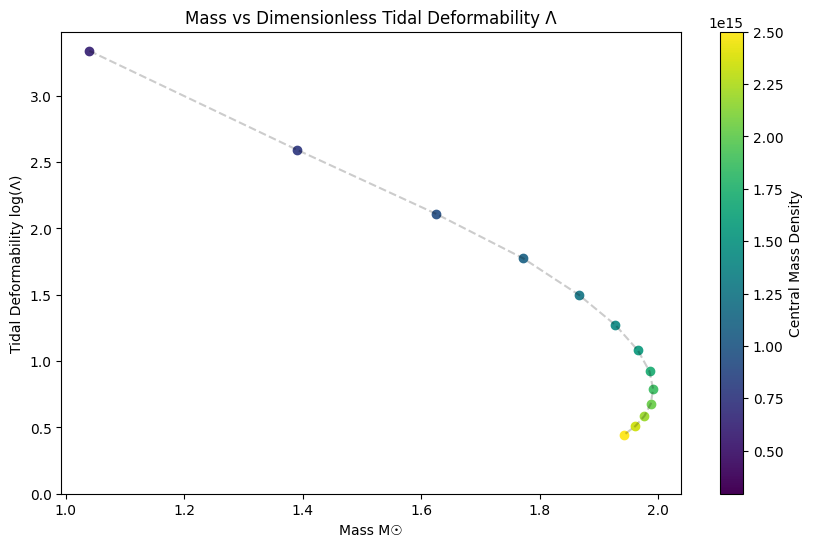

In [12]:
ppt.plot_tidal_deformability(masses, tidal_deformability, central_mass_densities)

Let's compare this with some observational constraints:








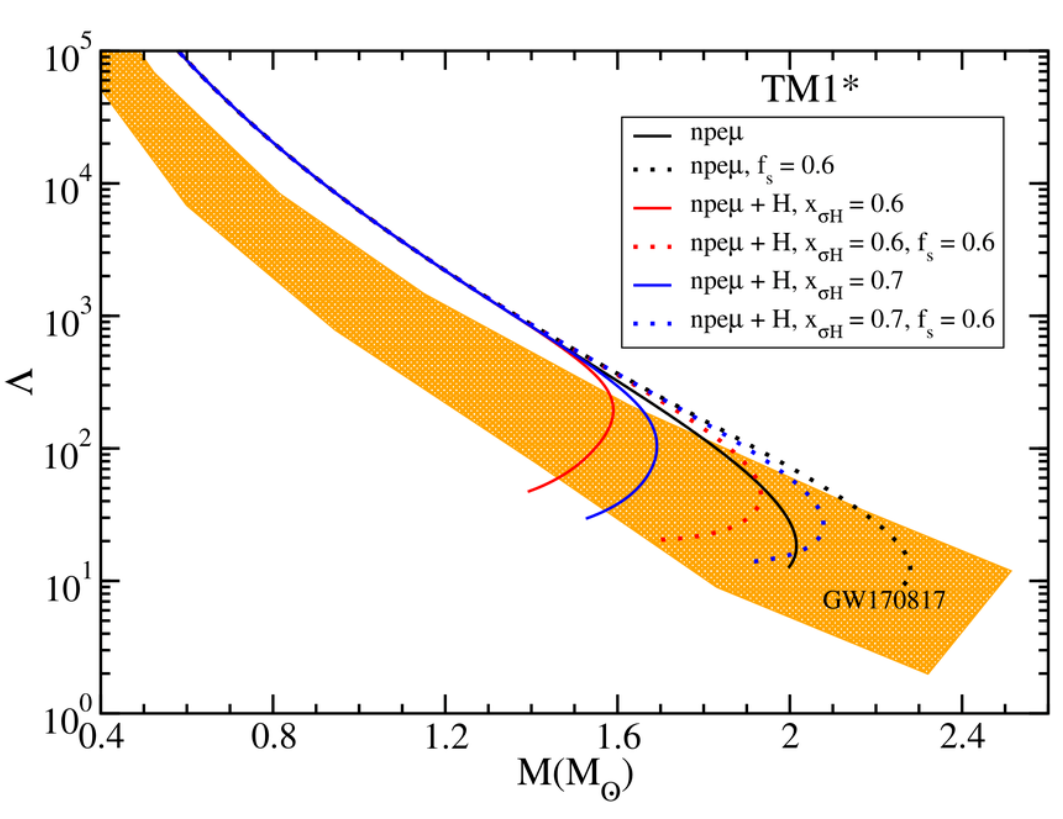
Our stars tracks are significantly further down and to the right than the tracks present in this image from Patra 2022, yet they still fall in/around the range constained by GW170817. This is yet another indicator of a physical neutron star structure, albeit very very stiff (or soft for lower masses).

This tidal deformability number can now be used to further define our EOS, as in make it more advanced and accurate, or it could also be used to compute binary tidal effects using the equation
$$\tilde{\Lambda} = \dfrac{16}{13}\dfrac{M_1+12M_2)M_1^4\Lambda_1+(M_2+12M_1)M_2^4\Lambda_2}{(M_1+M_2)^5}$$

This could then be compared with gravitational wave observations from LIGO/Virgo, or to experiment with different EOS to see how it affects merger dynamics.

That's all for this notebook, but feel free to explore with various tabular datasets, values of $\gamma$, and plots! Again, the full structure and thermodynamic information is available with the parameter full_data=True for piecewise_polytropic.py, neutron_star() function, organized as I explained above! Enjoy!